In [1]:
import numpy as np
import os
import cv2
import glob
import time
import random
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# Configurations tested
useDataNorm = False # Data normalization
useBatchNorm = False # Batch normalization
useXavierInit = True # Xavier initialization
useLinearDecay = True # Linear learning rate decay
imgSize = 60 # Image size (square image)
useCNN3 = False # Use 3 convolutional layers

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device to use is",device)

Device to use is cuda:0


In [3]:
# Dataset read and resize (INIT)
def readDataset(datasetPath, imgNewSz):
    imgList = []
    imgFiles = glob.glob(datasetPath+"*.jpg")
    random.shuffle(imgFiles) # Randomize position in image list
    for imgPath in imgFiles:
        img = cv2.imread(imgPath)/255.0
        # Resized image append in list
        imgResz = cv2.resize(img,(imgNewSz,imgNewSz), interpolation = cv2.INTER_AREA)
        imgResz = imgResz.reshape((3,imgNewSz,imgNewSz)) # Reshape to channels, Y axis, X axis (reshape for pytorch)
        imgList.append(imgResz)
    return imgList

imgNewSz = imgSize # New image size. Value in pixel
projectPath = os.getcwd()

# Reading faces images
facePath = projectPath + "\\Dataset\\Faces\\"
faceList = readDataset(facePath, imgNewSz)

# Reading non faces images
nonfacePath = projectPath + "\\Dataset\\Non Faces\\"
paths = [x[0] for x in os.walk(nonfacePath)]
nonfaceList = []
for path in paths:
    nonfaceList += readDataset(path+"\\", imgNewSz)

print("Total images in face dataset:",len(faceList))
print("Total images in non-face dataset:",len(nonfaceList))

Total images in face dataset: 7198
Total images in non-face dataset: 7125


In [4]:
# Data Augmentation
def dataAugmentation(imgListIn):
    imgListOut = []
    for img in imgListIn:
        imgListOut.append(img)
        # Flipped image
        imgFlip = np.flip(img.reshape(imgNewSz,imgNewSz,3),1).reshape(3,imgNewSz,imgNewSz)
        imgListOut.append(imgFlip)
        # Gamma correction (gamma1 and gamma2)
        gamma1 = 0.5
        gamma2 = 1.5
        imgGamma1 = np.power(img,1/gamma1)
        imgGamma2 = np.power(img,1/gamma2)
        imgListOut.append(imgGamma1)
        imgListOut.append(imgGamma2)
    return imgListOut

# Length Train-Validation and Test
faceSz = 70
faceSz = int(faceSz*len(faceList)/100)
nonfaceSz = 70
nonfaceSz = int(nonfaceSz*len(nonfaceList)/100)

# Face Train-Validation (with augmentation) / Test (without augmentation)
faceTrainVal = dataAugmentation(faceList[:faceSz])
faceTest = faceList[faceSz:]
print("Face train/validation:",len(faceTrainVal))
print("Face test:",len(faceTest))

# NonFace Train-Validation (with augmentation) / Test (without augmentation)
nonfaceTrainVal = dataAugmentation(nonfaceList[:nonfaceSz])
nonfaceTest = nonfaceList[nonfaceSz:]
print("Non face train/validation:",len(nonfaceTrainVal))
print("Non face test:",len(nonfaceTest))

Face train/validation: 20152
Face test: 2160
Non face train/validation: 19948
Non face test: 2138


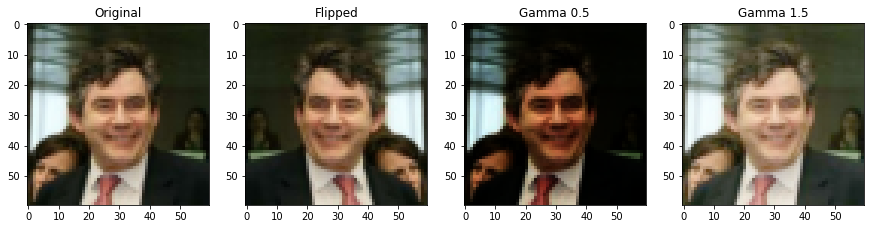

In [26]:
# Data augmentation preview
fig,axes = plt.subplots(1, 4,figsize=(15,15))
ax = axes.ravel()
titles = ["Original","Flipped","Gamma 0.5","Gamma 1.5"]
N = 30
for i in range(4):
    img = np.flip(faceTrainVal[N*4+i].reshape((imgNewSz,imgNewSz,3)),2)
    ax[i].imshow(img)
    ax[i].title.set_text(titles[i])

In [6]:
# Data Normalization
def dataWhitening(dataList,use=True):
    dataAvg = 0
    dataStd = 0
    if use:
        eps = 0.0001 # Constant to avoid overflow in division
        dataAvg = sum(dataList)/len(dataList)
        dataStd = np.sqrt(sum(np.power(dataList-dataAvg,2))/len(dataList))
        dataWhite = (dataList-dataAvg)/(dataStd+eps)
    else:
        dataWhite = dataList
    return dataWhite,dataAvg,dataStd

# Data DeNormalization (Reverse of Whitening)
def dataDeWhitening(data, mean, std, use=True):
    eps = 0.0001
    if use:
        dataDeWhite = data*(std+eps)+mean
    else:
        dataDeWhite = data
    return dataDeWhite

faceTrainVal,_,_ = dataWhitening(faceTrainVal,useDataNorm)
nonfaceTrainVal,_,_ = dataWhitening(nonfaceTrainVal,useDataNorm)

In [7]:
# Train and Validation List generation
def splitDataset(data, trainSz):
    numData = len(data)
    sZ = int(trainSz*numData/100)
    dataTrain = data[0:sZ]
    dataVal = data[sZ:]
    return dataTrain,dataVal

# Dividing in Train and Test
trainSz = 80 # Percentage
trainFace,valFace = splitDataset(faceTrainVal,trainSz)
trainNonFace,valNonFace = splitDataset(nonfaceTrainVal,trainSz)
print("Train Data:",len(trainFace)+len(trainNonFace))
print("Validation Data:",len(valFace)+len(valNonFace))

Train Data: 32079
Validation Data: 8021


In [8]:
# Converting data Train and Test to pytorch Loader

# Merging train and test data 
trainX = np.concatenate((trainFace,trainNonFace))
trainY = np.array([1]*len(trainFace)+[0]*len(trainNonFace)).astype(int)
valX = np.concatenate((valFace,valNonFace))
valY = np.array([1]*len(valFace)+[0]*len(valNonFace)).astype(int) # 1=Faces,0=Non Faces

# Pytorch tensors train data
trainTensorX = torch.Tensor(trainX)
trainTensorY = torch.Tensor(trainY).long()
trainData = TensorDataset(trainTensorX, trainTensorY)
# Pytorch tensors test data
valTensorX = torch.Tensor(valX)
valTensorY = torch.Tensor(valY).long()
valData = TensorDataset(valTensorX, valTensorY)

# Generating Loaders
batchSize = 100
trainLoader = torch.utils.data.DataLoader(trainData, batch_size=batchSize,shuffle=True, num_workers=2)
valLoader = torch.utils.data.DataLoader(valData, batch_size=batchSize,shuffle=True, num_workers=2)

In [9]:
# Network customizing according configurations

k1 = 5 # Kernel size cnn 1
k2 = 13 # Kernel size cnn 2
k3 = 5 # Kernel size cnn 3

# Convolutional Layers
cnn1 = nn.Conv2d(3, 16, k1) # Stride = 1, Padding = 0
cnn2 = nn.Conv2d(16, 32, k2) # Stride = 1, Padding = 0
cnn3 = nn.Conv2d(32, 32, k3) # Stride = 1, Padding = 0

if useCNN3:
    outSize = int(((((imgNewSz-k1+1)/2-k2+1)/2)-k3+1)/2) # Size after convolutional layers
else:
    outSize = int(((imgNewSz-k1+1)/2-k2+1)/2) # Size after convolutional layers

# Dense Layers
fc1 = nn.Linear(32 * outSize * outSize, 256)
fc2 = nn.Linear(256, 32)
fc3 = nn.Linear(32, 2)

# Xavier initialization
if useXavierInit:
    nn.init.xavier_uniform_(cnn1.weight) # Xavier initialization CNN1
    nn.init.xavier_uniform_(cnn2.weight) # Xavier initialization CNN2
    nn.init.xavier_uniform_(cnn3.weight) # Xavier initialization CNN2
    nn.init.xavier_uniform_(fc1.weight) # Xavier initialization FC1
    nn.init.xavier_uniform_(fc2.weight) # Xavier initialization FC2
    nn.init.xavier_uniform_(fc3.weight) # Xavier initialization FC3

# Batch Normalization
if useBatchNorm:
    batch1 = nn.BatchNorm2d(16)
    batch2 = nn.BatchNorm2d(32)
else:
    batch1 = nn.Identity()
    batch2 = nn.Identity()

In [10]:
# Neural Network Class
class Net(nn.Module):
    def __init__(self):
        # Neural Network layers
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            cnn1,
            batch1,
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        self.layer2 = nn.Sequential(
            cnn2,
            batch2,
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        self.layer3 = nn.Sequential(
            cnn3,
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        self.layer4 = nn.Sequential(fc1,nn.ReLU())
        self.layer5 = nn.Sequential(fc2,nn.ReLU())
        self.layer6 = nn.Sequential(fc3)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        if useCNN3:
            out = self.layer3(out)
        out = out.view(-1, 32 * outSize * outSize)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        return out

net = Net().to(device) # Send CNN to GPU if available

In [11]:
# Loss fuinction
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(net.parameters(), lr=0.0025, momentum=0.9)

# Learning rate scheme
lrStart = 0.005 # Start learning rate
lrFinal = 0.0001 # Final learning rate
maxEpochs = 20
lrArr = np.linspace(lrStart,lrFinal,maxEpochs)

In [12]:
# Lists for train results
trainLoss = [] # Stores train loss at each iteration
trainLossEpoch = [] # Stores train Loss per Epoch
trainAcc = [] # Stores train accuracy per mini batch
trainPredict = [] # Stores prediction labels

# List for validation results
valLossEpoch = [] # Stores train Loss per Epoch
valAcc = [] # Stores train accuracy per mini batch
valPredict = [] # Stores prediction labels

# List learning rate
lrList = []

In [13]:
# Fiting
for epoch in range(maxEpochs):
    lossBatch = 0.0
    correct = 0
    total = 0
    
    # Change learning rate according scheme
    if useLinearDecay: 
        optimizer.param_groups[0]['lr'] = lrArr[epoch] 
    else:
        optimizer.param_groups[0]['lr'] = 0.0025
    
    # Train fit
    for i, trainData in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        trainIn, trainL = trainData
        trainIn, trainL = trainIn.to(device), trainL.to(device) # Copy to GPU if available 
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # Fiting
        trainOut = net.forward(trainIn)
        loss = criterion(trainOut, trainL)
        loss.backward()
        optimizer.step()
        
        # Storing loss
        trainLoss.append(loss.item())
        lossBatch += loss.item()
    
        # Storing accuracy
        _, predicted = torch.max(trainOut.data, 1)
        total += len(trainL)
        correct += (predicted == trainL).sum().item()
        trainPredict += (predicted).tolist()
    
    # Train loss and accuracy per epoch 
    trainLossEpoch.append(lossBatch/(i+1))
    trainAcc.append(correct/total)
    lossBatch = 0.0
    total = 0
    correct = 0
    
    # Validation prediction
    for j, valData in enumerate(valLoader):
        with torch.no_grad():
            valIn, valL = valData
            valIn, valL = valIn.to(device), valL.to(device) # Copy to GPU if available

            valOut = net(valIn)
            # Storing Loss
            loss = criterion(valOut, valL)
            lossBatch += loss.item()
            # Accuracy
            _, predicted = torch.max(valOut.data, 1)
            total += len(valL)
            correct += (predicted == valL).sum().item()
            valPredict += (predicted).tolist()
    
    # Validation loss and accuracy per epoch
    valLossEpoch.append(lossBatch/(j+1))
    valAcc.append(correct/total)
    lossBatch = 0.0
    total = 0
    correct = 0
    lrList.append(optimizer.param_groups[0]['lr'])
    
    # Print results
    print("Epoch %d -> Train: Loss: %.3f, Accuracy: %.3f // Validation: Loss: %.3f, Accuracy: %.3f // lr: %.4f" 
          %(epoch+1,trainLossEpoch[epoch],trainAcc[epoch],valLossEpoch[epoch],valAcc[epoch],lrList[epoch]))
    
print('Finished Training')

Epoch 1 -> Train: Loss: 0.238, Accuracy: 0.891 // Validation: Loss: 0.095, Accuracy: 0.965 // lr: 0.0050
Epoch 2 -> Train: Loss: 0.059, Accuracy: 0.978 // Validation: Loss: 0.070, Accuracy: 0.972 // lr: 0.0047
Epoch 3 -> Train: Loss: 0.036, Accuracy: 0.987 // Validation: Loss: 0.051, Accuracy: 0.981 // lr: 0.0045
Epoch 4 -> Train: Loss: 0.024, Accuracy: 0.992 // Validation: Loss: 0.067, Accuracy: 0.977 // lr: 0.0042
Epoch 5 -> Train: Loss: 0.013, Accuracy: 0.996 // Validation: Loss: 0.061, Accuracy: 0.977 // lr: 0.0040
Epoch 6 -> Train: Loss: 0.008, Accuracy: 0.998 // Validation: Loss: 0.045, Accuracy: 0.983 // lr: 0.0037
Epoch 7 -> Train: Loss: 0.006, Accuracy: 0.998 // Validation: Loss: 0.053, Accuracy: 0.981 // lr: 0.0035
Epoch 8 -> Train: Loss: 0.002, Accuracy: 1.000 // Validation: Loss: 0.051, Accuracy: 0.982 // lr: 0.0032
Epoch 9 -> Train: Loss: 0.001, Accuracy: 1.000 // Validation: Loss: 0.050, Accuracy: 0.983 // lr: 0.0029
Epoch 10 -> Train: Loss: 0.001, Accuracy: 1.000 // Vali

(0.75, 1)

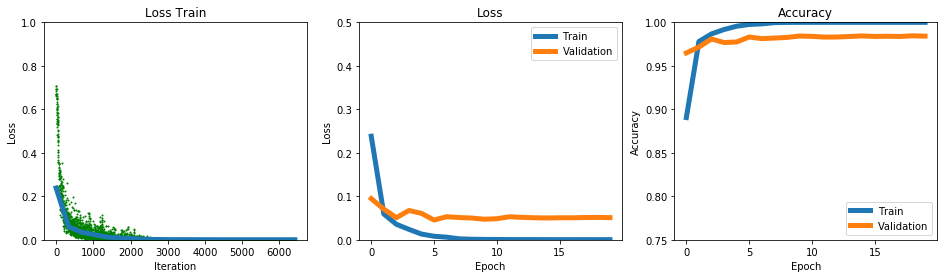

In [18]:
# Plot loss
xLoss = np.arange(0,len(trainLoss))
xLossEpoch = np.linspace(0,len(trainLoss),len(trainLossEpoch)).astype(int)
fig,axes = plt.subplots(1, 3,figsize=(16,4))
axes[0].plot(xLoss, trainLoss, color='green', marker='o', linestyle='none', markersize=1)
axes[0].plot(xLossEpoch, trainLossEpoch, linewidth=5)
axes[0].set_title("Loss Train")
axes[0].set_ylabel("Loss")
axes[0].set_xlabel("Iteration")
axes[0].set_ylim([0,1.0])

axes[1].plot(trainLossEpoch, linewidth=5)
axes[1].plot(valLossEpoch, linewidth=5)
axes[1].set_title("Loss")
axes[1].set_ylabel("Loss")
axes[1].set_xlabel("Epoch")
axes[1].legend(["Train","Validation"])
axes[1].set_ylim([0,0.5])

# Plot train-validation Accuracy
axes[2].plot(trainAcc, linewidth=5)
axes[2].plot(valAcc, linewidth=5)
axes[2].set_title("Accuracy")
axes[2].set_ylabel("Accuracy")
axes[2].set_xlabel("Epoch")
axes[2].legend(["Train","Validation"], loc="lower right")
axes[2].set_ylim([0.75,1])

In [19]:
# Merging train and test data (1=Faces,2=Non Faces)
faceTest,faceMean,faceStd = dataWhitening(faceTest,useDataNorm)
nonfaceTest,nonfaceMean,nonfaceStd = dataWhitening(nonfaceTest,useDataNorm)

testX = np.concatenate((faceTest,nonfaceTest))
testY = np.array([1]*len(faceTest)+[0]*len(nonfaceTest)).astype(int)

# Pytorch tensors test data
testTensorX = torch.Tensor(testX)
testTensorY = torch.Tensor(testY).long()
testData = TensorDataset(testTensorX, testTensorY)

# Generating Loaders
batchSize = 100
testLoader = torch.utils.data.DataLoader(testData, batch_size=batchSize,shuffle=False, num_workers=2)

In [20]:
# Test data evaluation
correctList = []
predictedList = []
correct = 0
total = 0
with torch.no_grad():
    for testData in testLoader:
        testIn, testL = testData
        testIn, testL = testIn.to(device), testL.to(device)
        testOut = net(testIn)
        _, predicted = torch.max(testOut.data, 1)
        total += len(testL)
        predictedList += predicted.tolist()
        correct += (predicted == testL).sum().item()
        correctList += (predicted == testL).tolist()

print('Accuracy test images: %2.3f %%' % (100 * correct / total))

Accuracy test images: 98.883 %


Face Accuracy: 0.988
Non Face Accuracy: 0.989


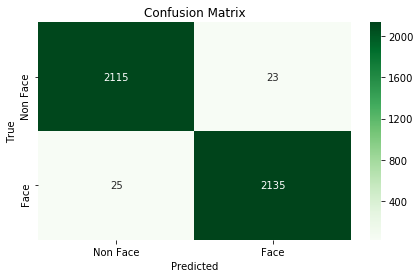

In [21]:
# Test data Confusion Matrix
axis_labels = ["Non Face","Face"] # Class 0: Non Face, Class 1: Face
confM = confusion_matrix(testY, np.array(predictedList))
fig, ax = plt.subplots(figsize=(7,4)) 
sns.heatmap(confM, annot=True,cmap="Greens",fmt='g', xticklabels=axis_labels, yticklabels=axis_labels,ax=ax)
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')

# Test data TPR and TNR
TNR,TPR = np.diag(confM)/np.sum(confM,axis=1)
print("Face Accuracy:",np.round(TPR,3))
print("Non Face Accuracy:",np.round(TNR,3))

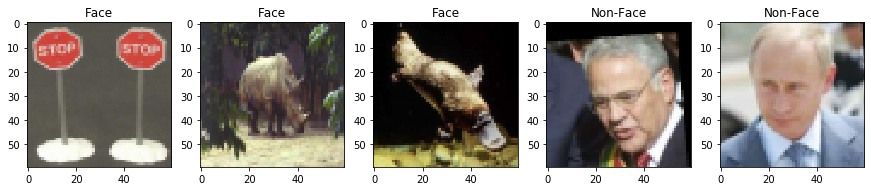

In [22]:
# Plot some wrong labeled data
correctArr = np.array(correctList)
wrongIdx = np.argwhere(correctArr==False).ravel()
Q = 5 # 5 Random Images
N = np.random.randint(0,len(wrongIdx),Q) 
# Plot
fig,axes = plt.subplots(1, Q,figsize=(15,15))
ax = axes.ravel()
for i in range(len(N)):
    if testY[wrongIdx[N[i]]] == 1:
        img = dataDeWhitening(testX[wrongIdx[N[i]]],faceMean,faceStd,useDataNorm)
        title = "Non-Face"
    else:
        img = dataDeWhitening(testX[wrongIdx[N[i]]],nonfaceMean,nonfaceStd,useDataNorm)
        title = "Face"
    img = np.flip(img.reshape((imgNewSz,imgNewSz,3)),2)
    ax[i].imshow(img)
    ax[i].title.set_text(title)